In [1]:
import sys


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
from matplotlib import gridspec
import time
import tensorflow as tf
from sklearn.preprocessing import StandardScaler


import os
os.environ['CUDA_VISIBLE_DEVICES']="3" #"1"

physical_devices = tf.config.list_physical_devices('GPU') 

tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [2]:
#Read in the data
data = pd.read_pickle("datafiles/data.pkl")
theta_unknown_S = data[['e_px','e_py','e_pz','jet_pt','jet_eta','jet_phi','jet_dphi','jet_qtnorm']].to_numpy()

scaler_data = StandardScaler()
scaler_data.fit(theta_unknown_S)

StandardScaler()

In [3]:
#Read in the MC
mc = pd.read_pickle("/clusterfs/ml4hep/bpnachman/H1/july16/datasets/Rapgap_nominal.pkl")


theta0_S = mc[['e_px','e_py','e_pz','jet_pt','jet_eta','jet_phi','jet_dphi','jet_qtnorm']].to_numpy()
theta0_G = mc[['gene_px','gene_py','gene_pz','genjet_pt','genjet_eta','genjet_phi','genjet_dphi','genjet_qtnorm']].to_numpy()
weights_MC_sim = mc['wgt']
pass_reco = np.array(mc['pass_reco'])
pass_truth = np.array(mc['pass_truth'])
pass_fiducial = np.array(mc['pass_fiducial'])

del mc
gc.collect()

22

In [4]:
NNweights_step2 = np.ones(len(theta0_S))
for i in range(5):
    mymodel = tf.keras.models.load_model("models/Rapgap_nominal_iteration"+str(i)+"_step2", compile=False)
    NNweights_step2_hold = mymodel.predict(scaler_data.transform(theta0_G),batch_size=10000)
    NNweights_step2_hold = NNweights_step2_hold/(1.-NNweights_step2_hold)
    NNweights_step2_hold = NNweights_step2_hold[:,0]
    NNweights_step2_hold = np.squeeze(np.nan_to_num(NNweights_step2_hold,posinf=1))
    NNweights_step2_hold[pass_truth==0] = 1.
    NNweights_step2 = NNweights_step2_hold*NNweights_step2

# Getting Q^2


weights=weights_MC_sim[pass_fiducial==1]*NNweights_step2[pass_fiducial==1]

e_px = theta0_G[:,0]
e_py = theta0_G[:,1]

jet_pT = theta0_G[:,3]
jet_phi = theta0_G[:,3]

jet_px = np.multiply(jet_pT, np.cos(jet_phi))
jet_py = np.multiply(jet_pT, np.sin(jet_phi))

jet_qT = np.sqrt(np.square(e_px + jet_px) + np.square(e_py + jet_py))
jet_qT_norm = theta0_G[:,7]

one_over_Q = np.divide(jet_qT_norm, jet_qT)
Q = np.divide(1, one_over_Q)
Q_sq = np.square(Q, Q)

In [5]:
#bin_for_Q_sq = []


Q_squared,_,_=plt.hist(Q_sq[pass_fiducial==1],
                weights=weights_MC_sim[pass_fiducial==1]*NNweights_step2[pass_fiducial==1],
                density=True,histtype="step",color="black",ls=":",label="MC + step 2")

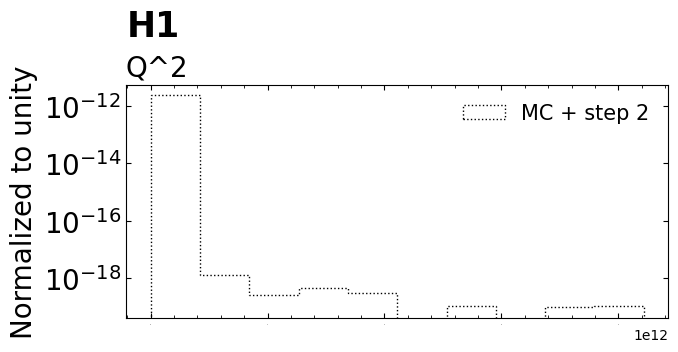

In [10]:
fig = plt.figure(figsize=(7, 5)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[2,1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=0)
plt.yticks(fontsize=20)

Q_squared,_,_=plt.hist(Q_sq[pass_fiducial==1],
                weights=weights_MC_sim[pass_fiducial==1]*NNweights_step2[pass_fiducial==1],
                density=True,histtype="step",color="black",ls=":",label="MC + step 2")

plt.ylabel("Normalized to unity",fontsize=20)
plt.title("Q^2",loc="left",fontsize=20)
plt.text(0.05, 1.25,'H1', horizontalalignment='center', verticalalignment='center', transform = ax0.transAxes, fontsize=25, fontweight='bold')
plt.legend(frameon=False,fontsize=15)
plt.locator_params(axis='x', nbins=5)
plt.yscale("log")

plt.show()

